# Workout progress


## Data import

In [118]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [119]:
# Load data
df = pd.read_csv('data.csv')

# Drop rows with all missing values
df = df.dropna(how='all')

## Calculate average weight

The training is done in a series of excersises. The excercises are done in a 
series of sets. The set is done in a series of repetitions. The weight used in 
each set is recorded. The average weight is calculated for each excercise using
this formula:

$$
WSavg = W \times \frac{Rsucc}{Rgoal}
$$

$$
WEavg = \frac{\sum_{i=1}^{n} WSavg_i}{n}
$$

where:
- $WSavg$ is the average weight for a set
- $W$ is the weight used in the set
- $Rsucc$ is the number of successful repetitions
- $Rgoal$ is the goal number of repetitions
- $WEavg$ is the average weight for the excercise
- $WSavg_i$ is the average weight for the $i$-th set
- $n$ is the number of sets

In [120]:
# Add weighted_average column for each set
df['weighted_average'] = (
    df['weight'] * df['repetitions'] / df['repetitions_goal'])

# Calculate average weight for each exercise on each day
average_weights = df.groupby(
    ['date', 'category', 'exercise'])['weighted_average'].mean().reset_index()

# Sort the dataframe by exercise and date
average_weights = average_weights.sort_values(['exercise', 'date'])

## Average weight graph

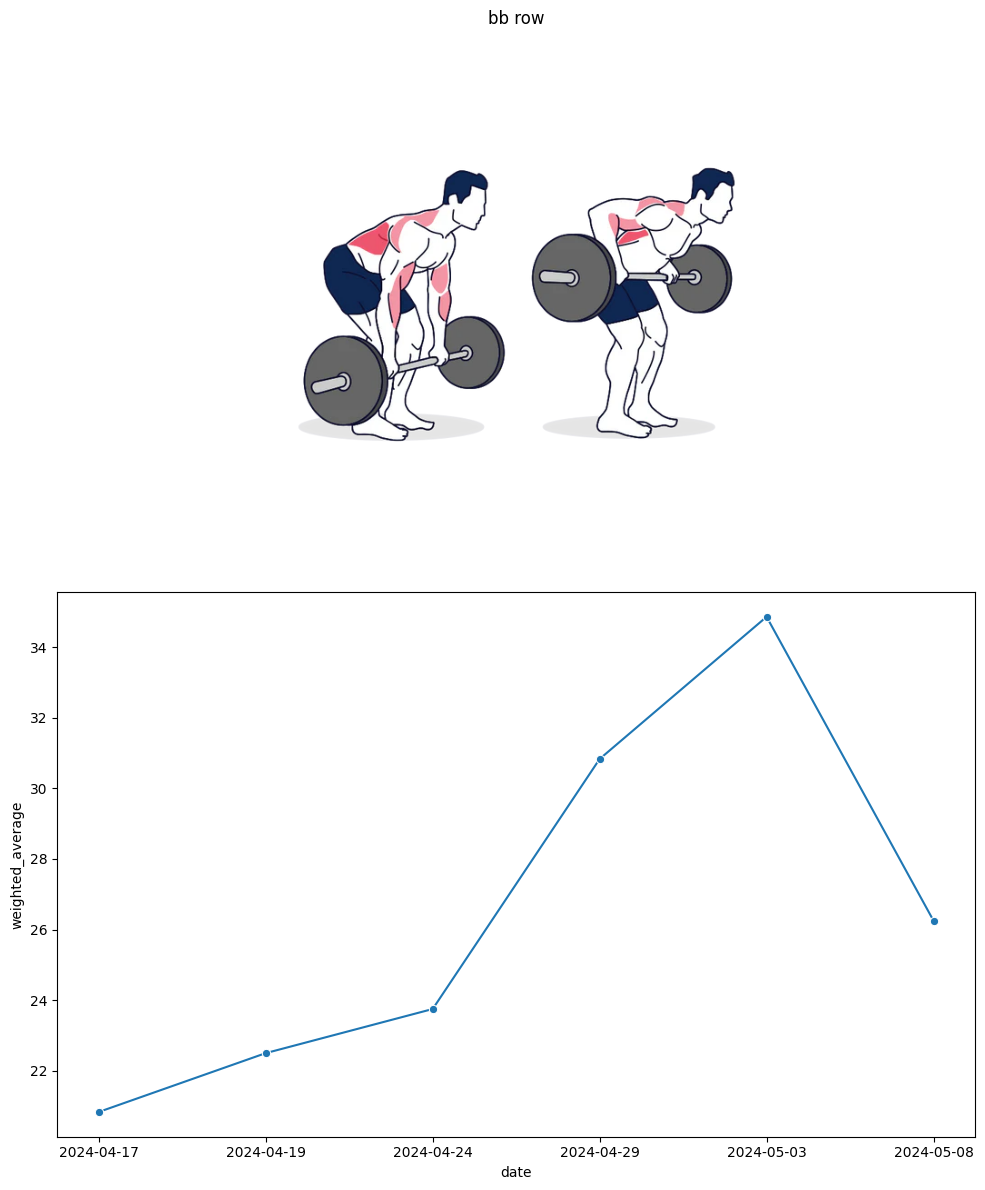

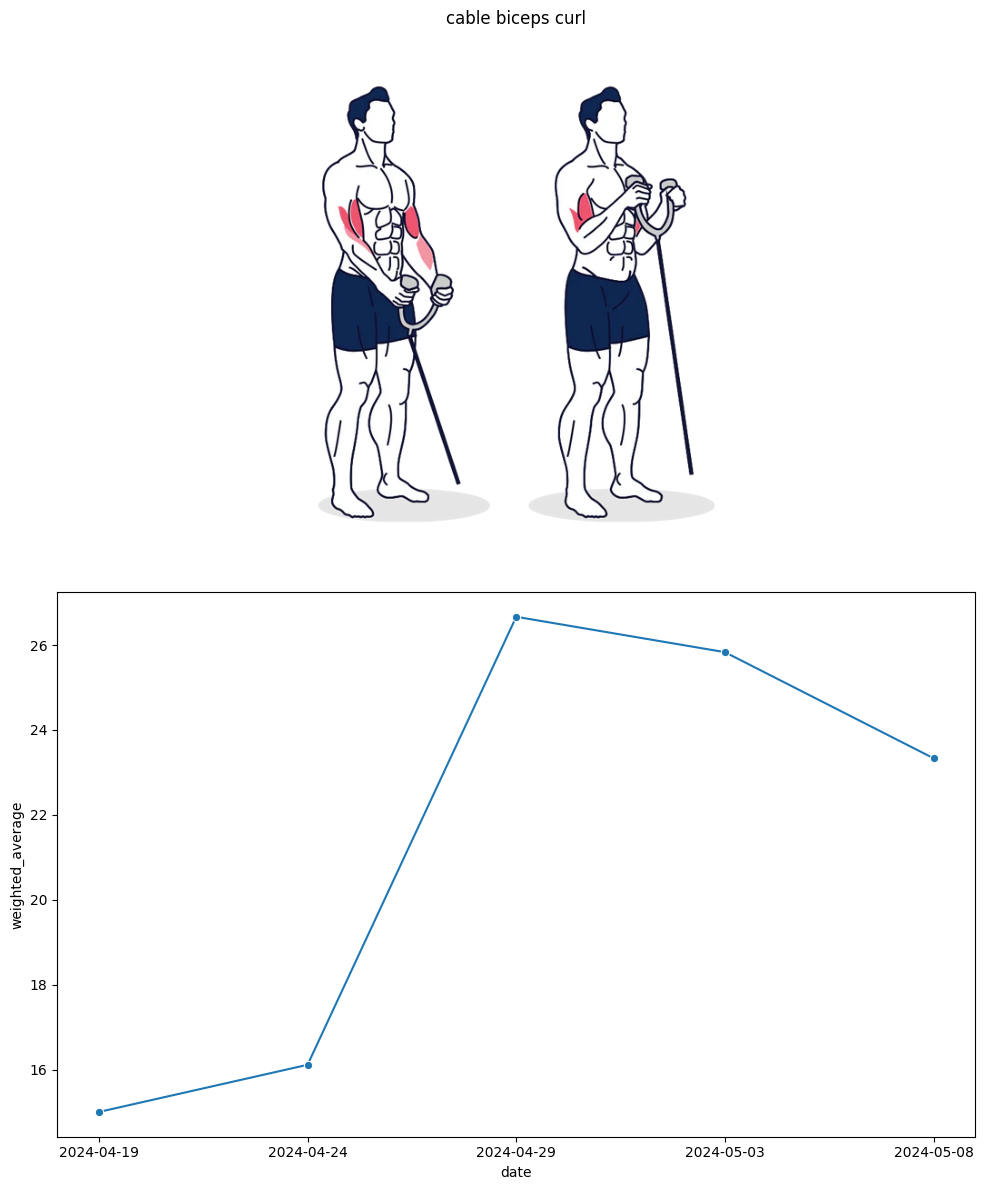

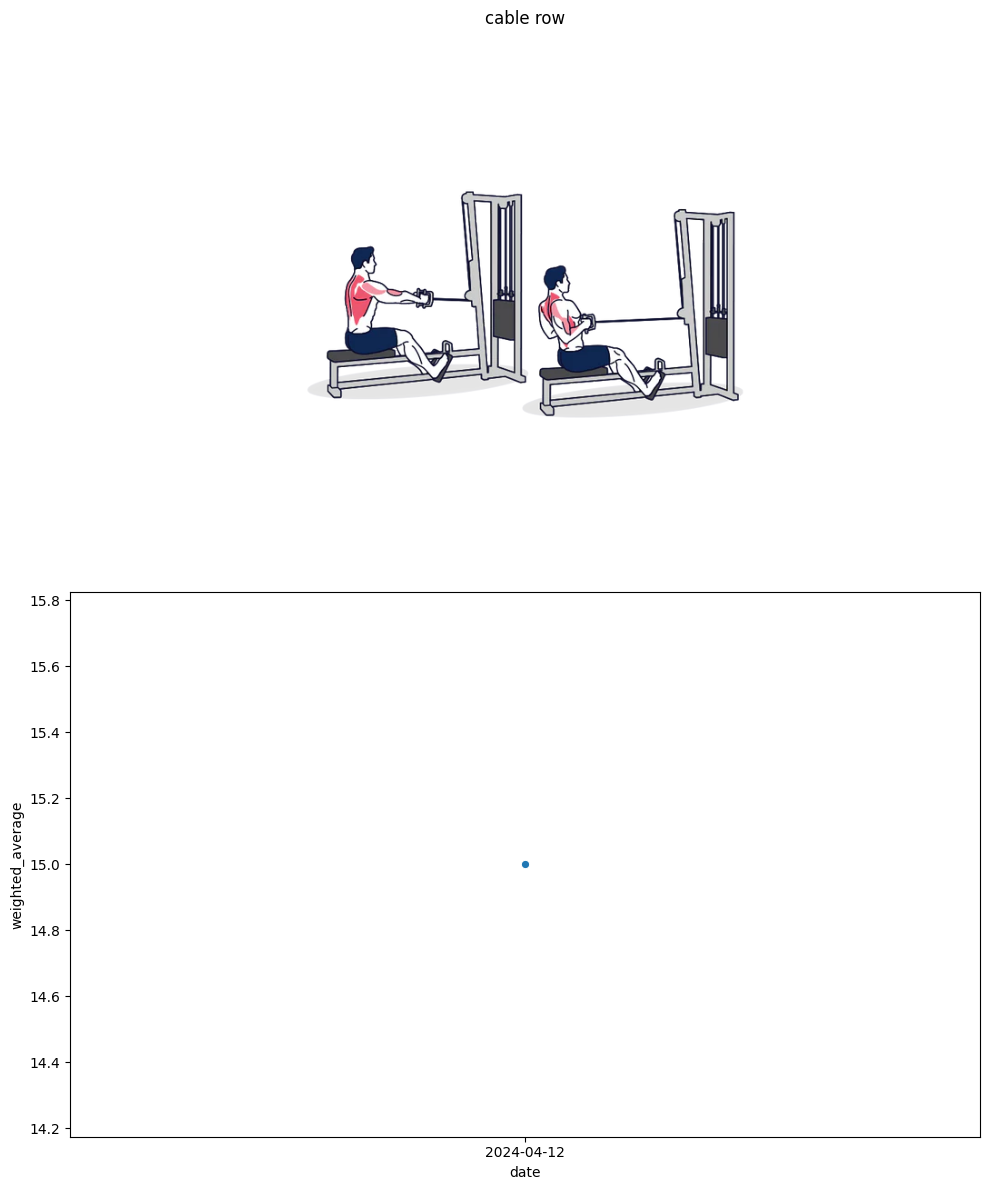

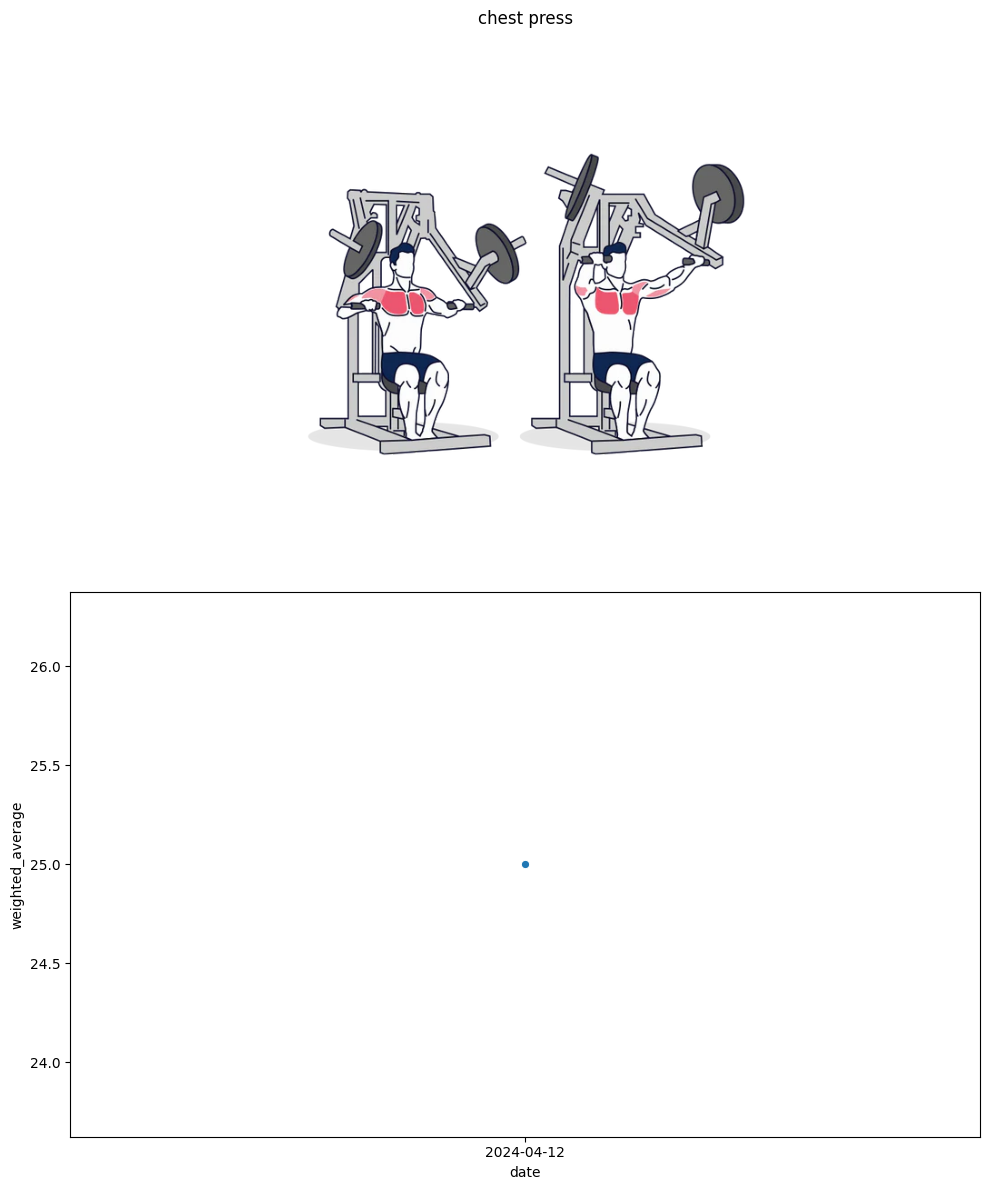

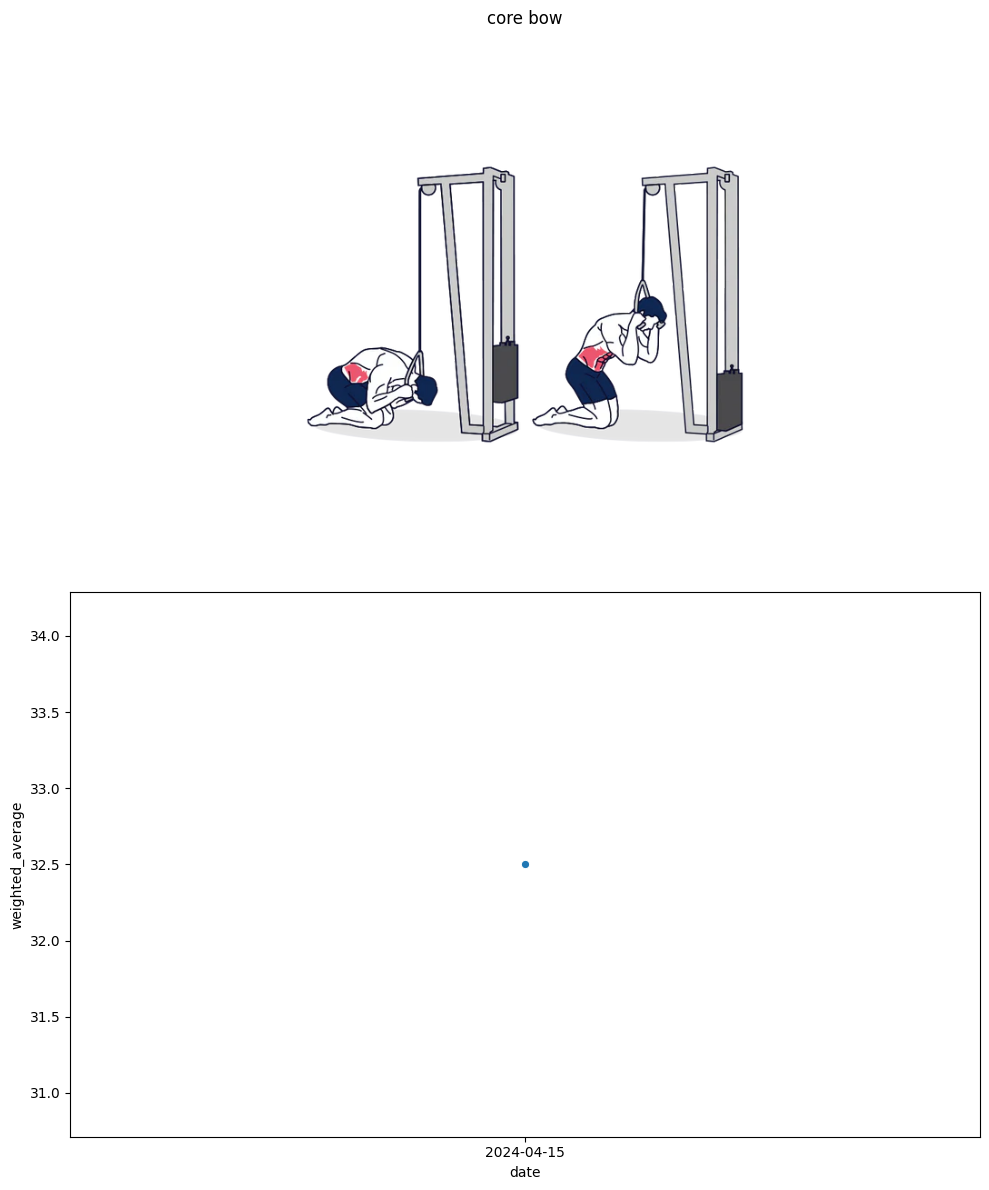

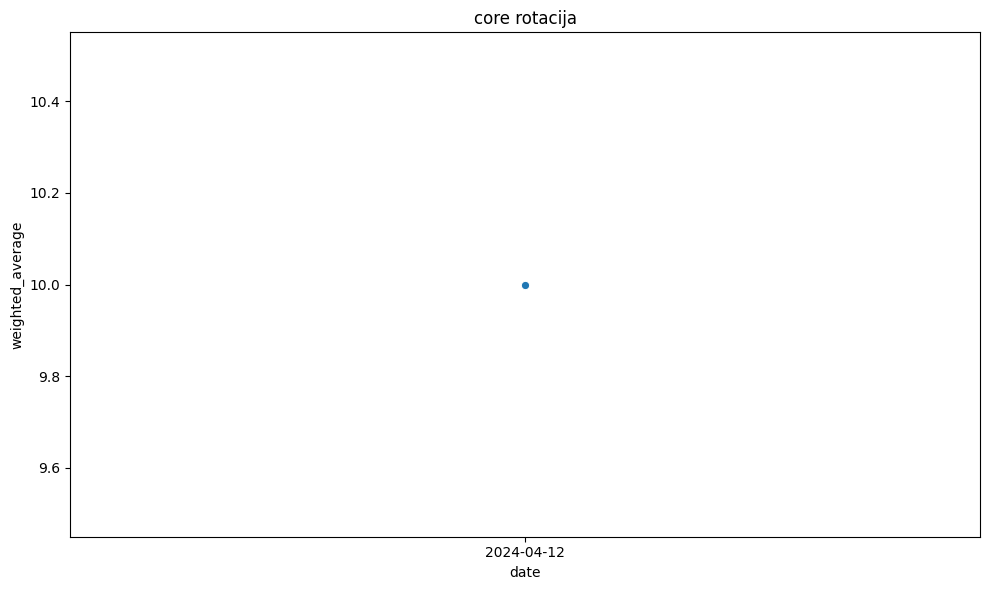

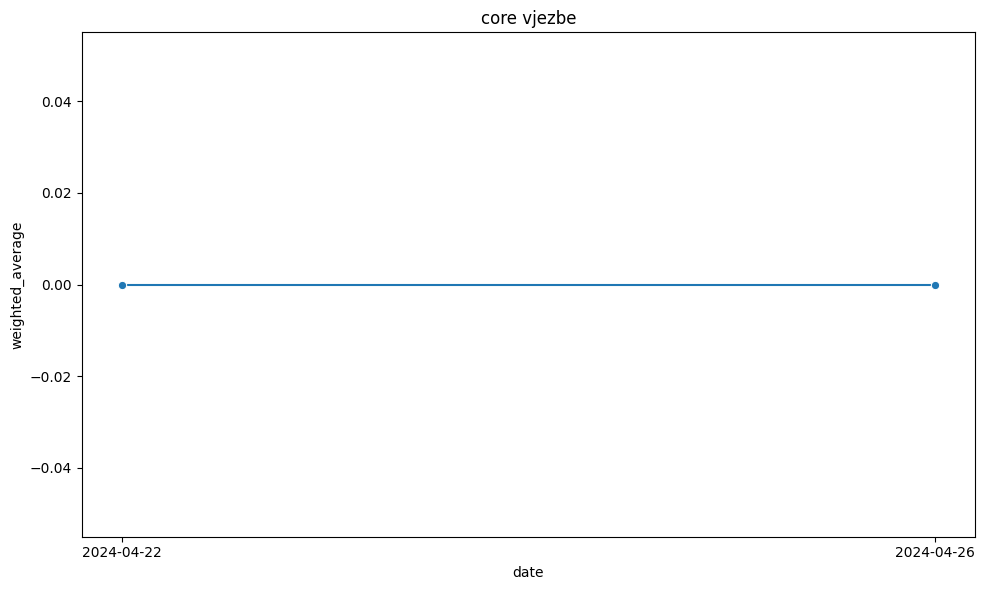

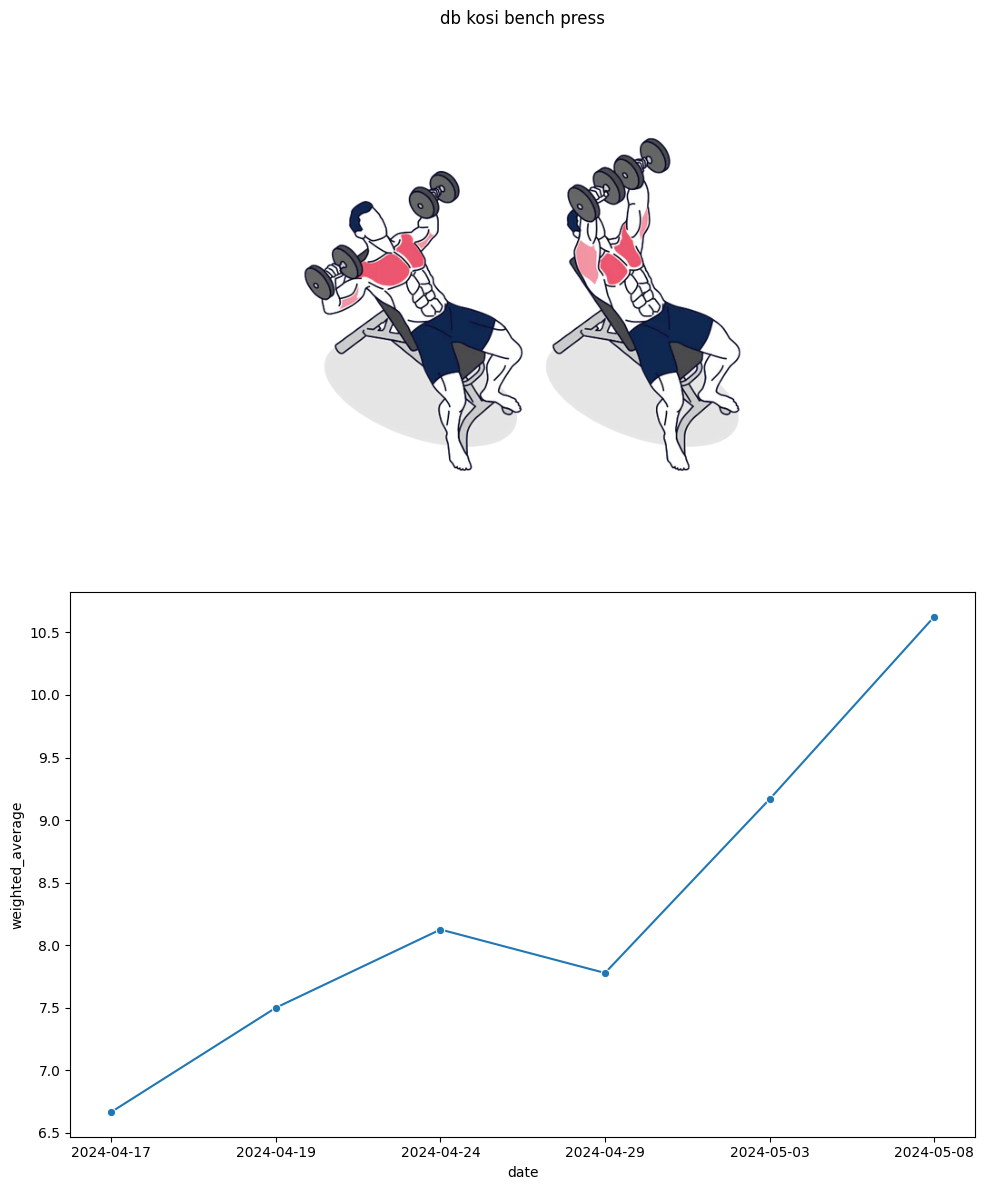

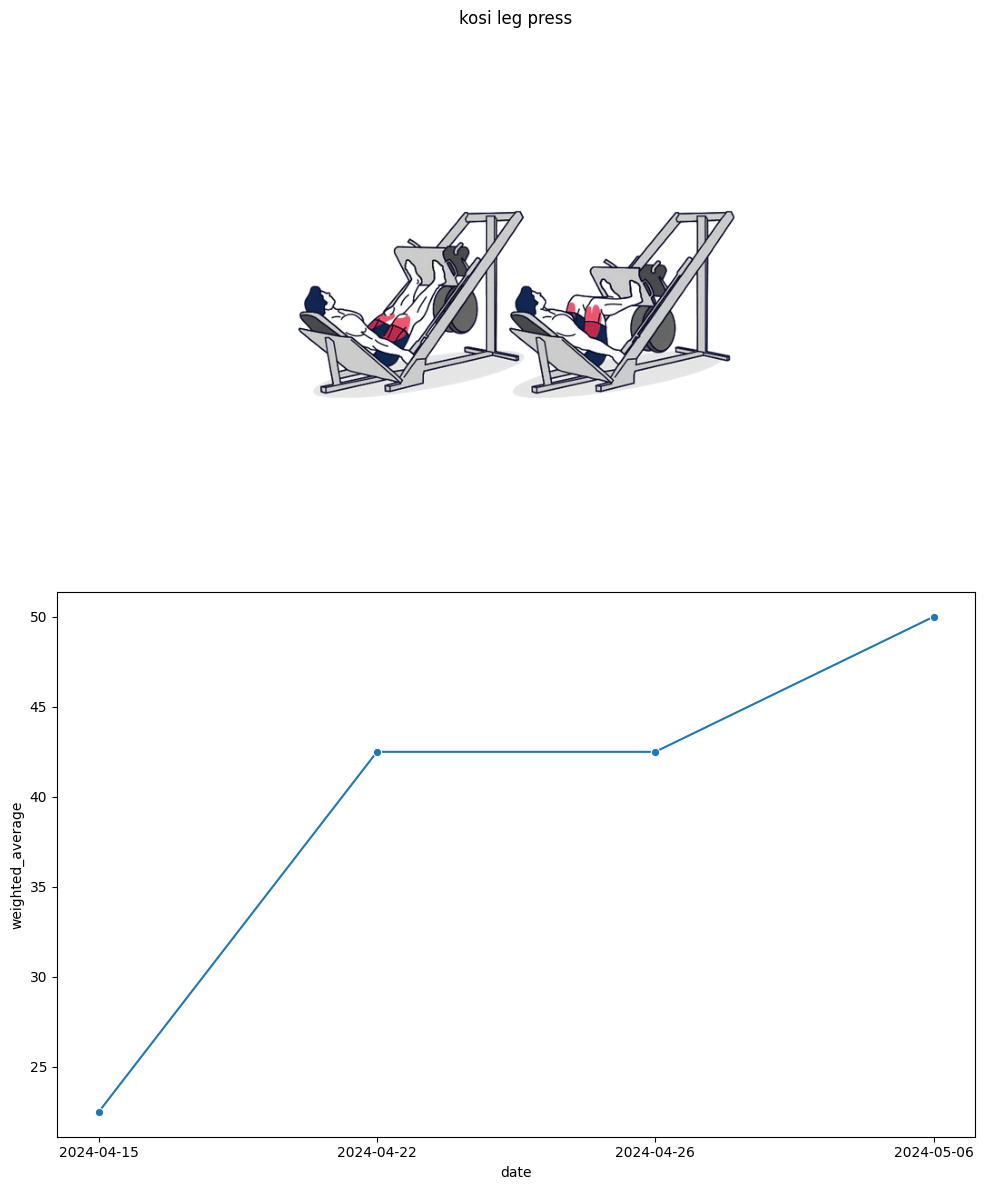

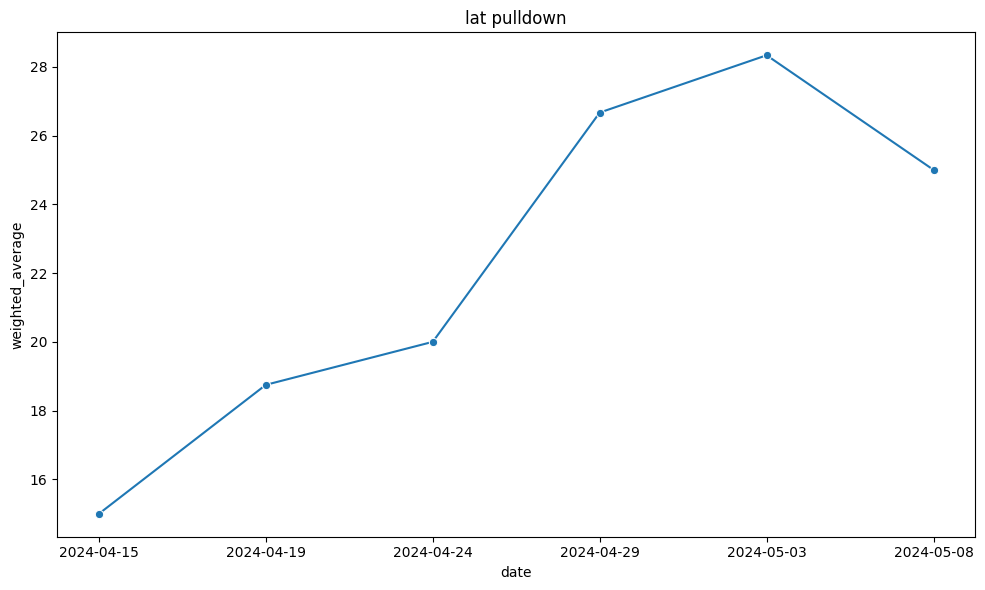

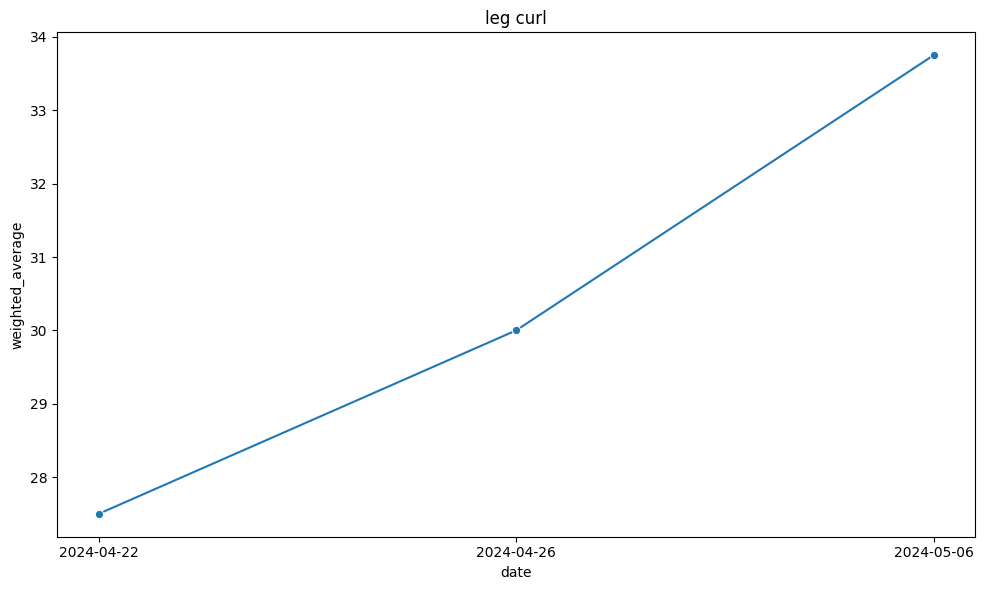

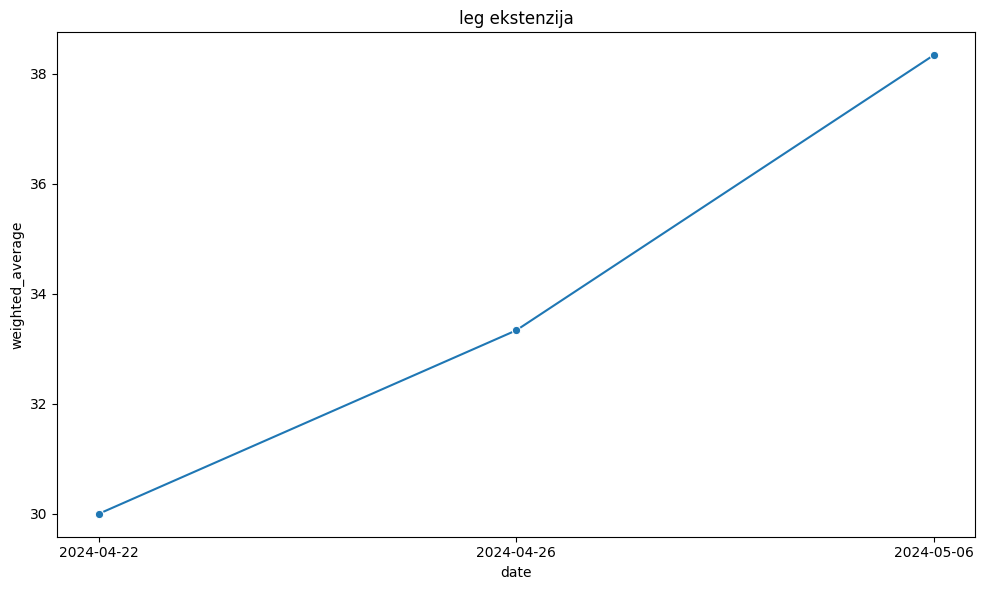

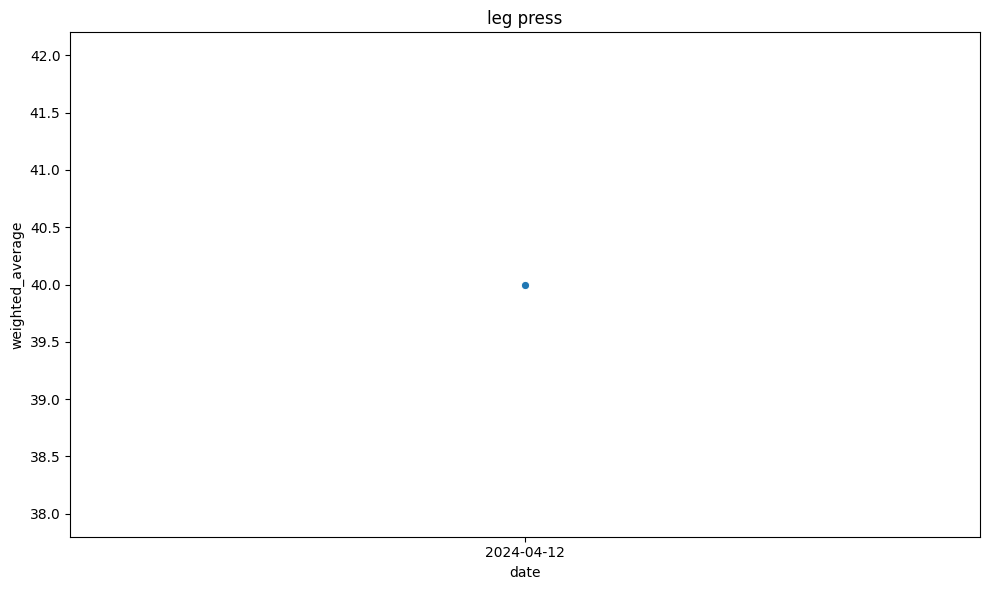

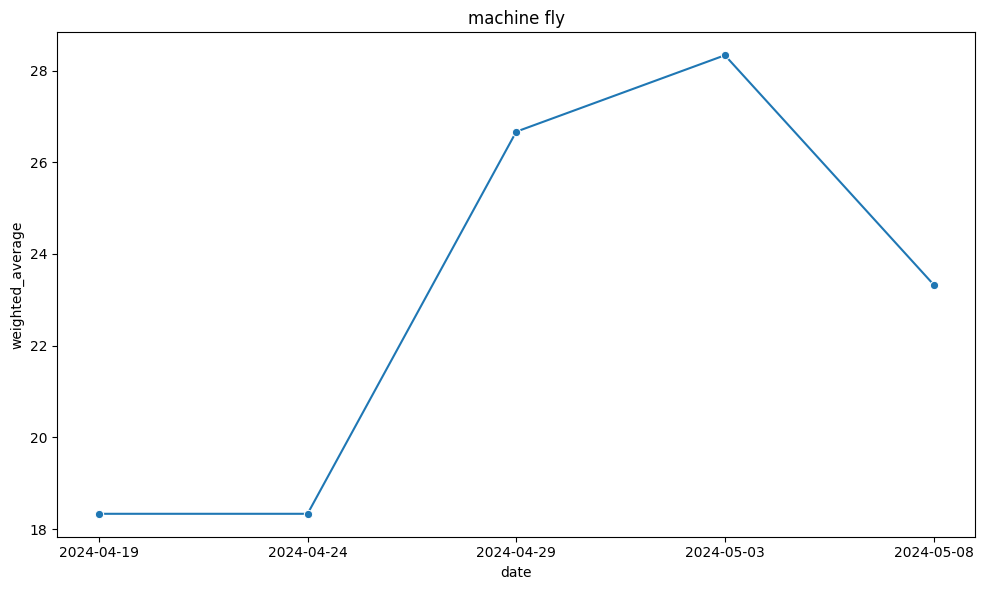

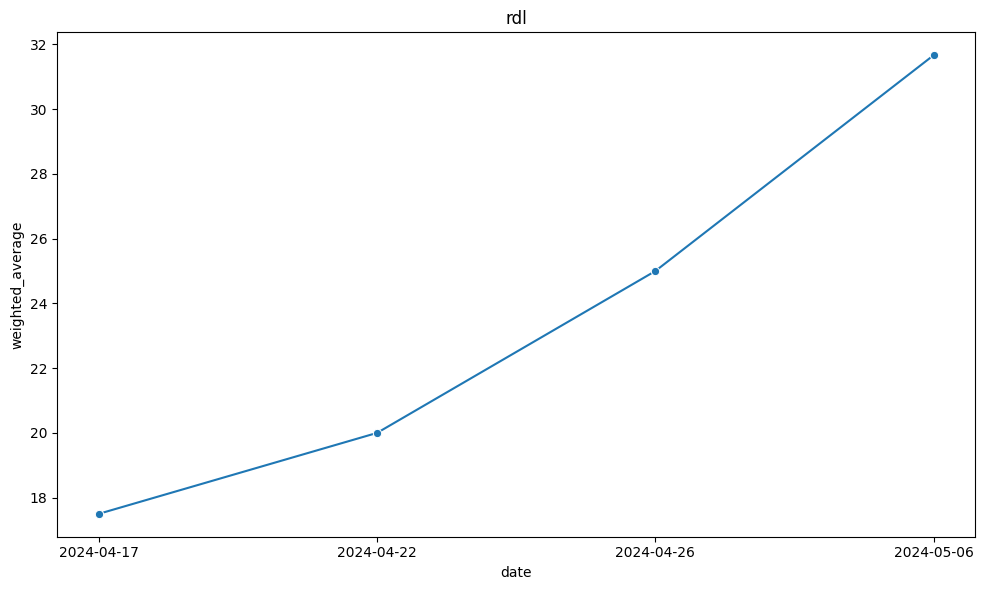

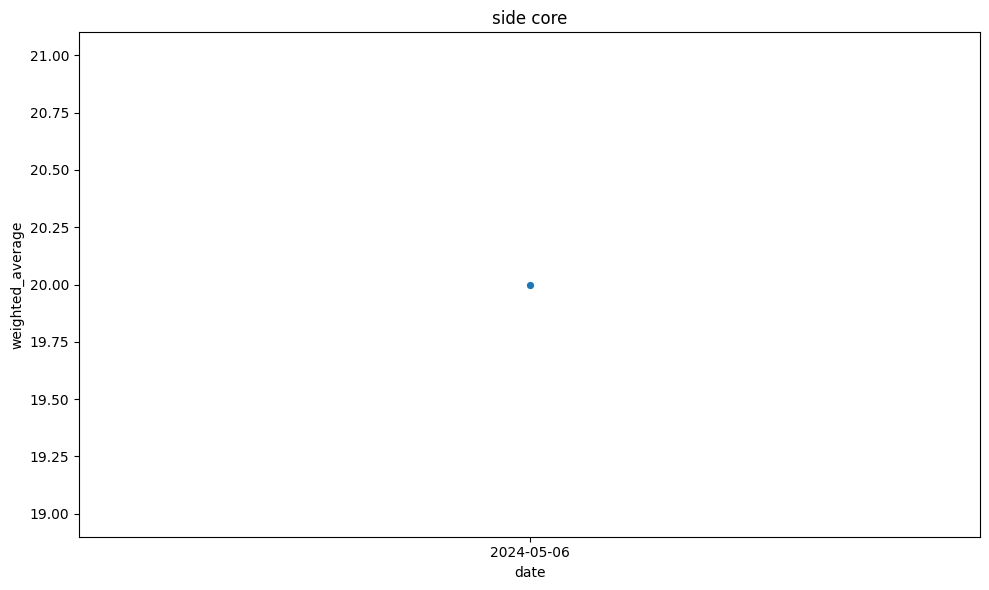

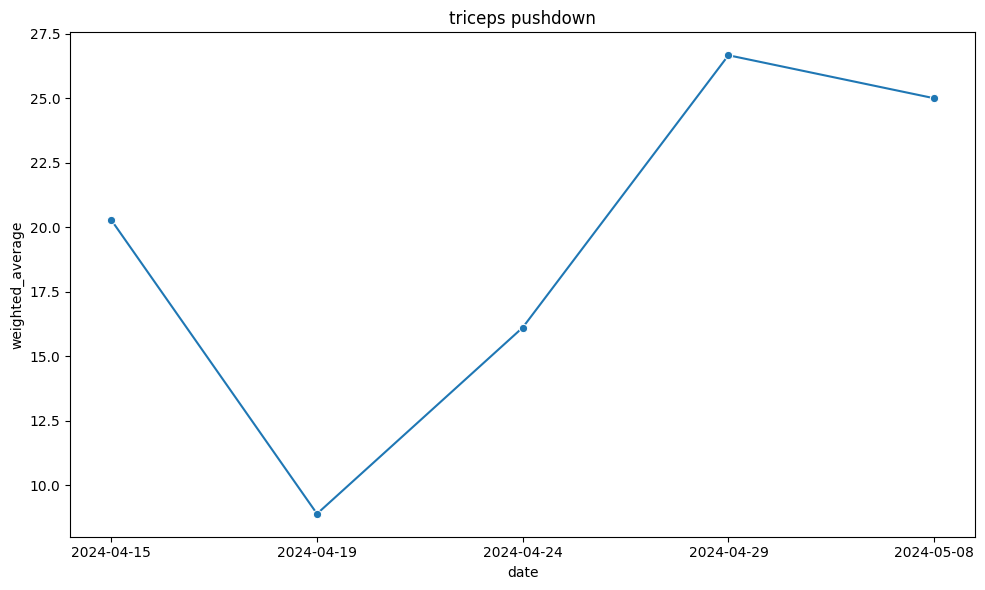

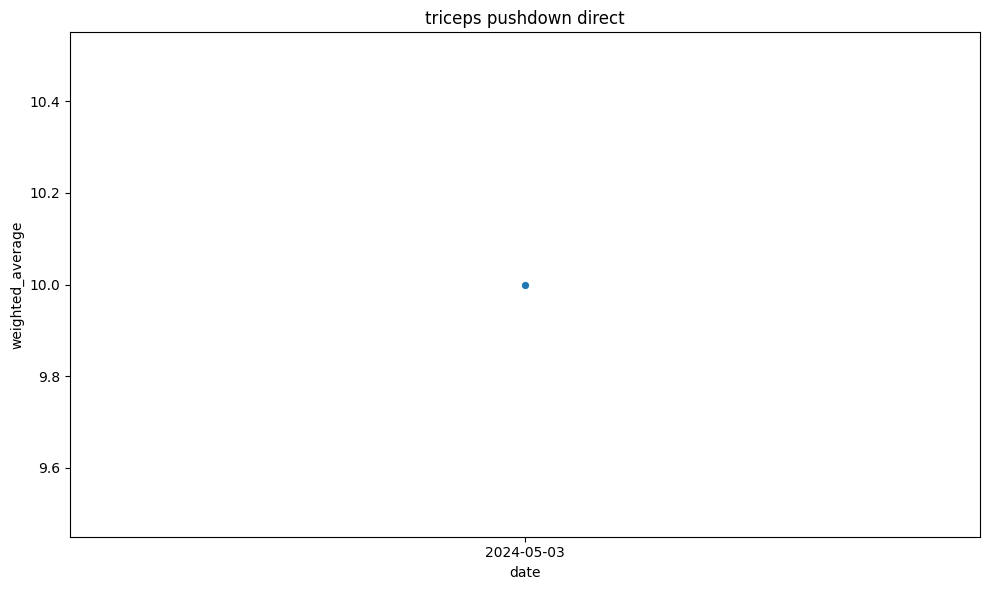

In [121]:
# Plot the average weight for each exercise
exercises = average_weights['exercise'].unique()
for exercise in exercises:
    exercise_data = average_weights[average_weights['exercise'] == exercise]

    # Check if the image file exists
    img_path = f'img/{exercise.replace(' ', '_')}.webp'  # adjust the file path and extension as needed
    if os.path.exists(img_path):
        # If the file exists, create 2 subplots and display the image
        fig, axs = plt.subplots(2, 1, figsize=(10, 12))

        img = imread(img_path)
        axs[0].imshow(img)
        axs[0].axis('off')  # hide the axis
        axs[0].set_title(exercise)

        sns.lineplot(x='date', y='weighted_average', data=exercise_data, 
                     marker='o', ax=axs[1])
    else:
        # If the file doesn't exist, create 1 subplot
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.lineplot(x='date', y='weighted_average', data=exercise_data, 
                     marker='o', ax=ax)
        ax.set_title(exercise)

    plt.tight_layout()
    plt.show()

## Grade training

The training is graded using the following formula:

$$
ES = 
\begin{cases}
  0 & \text{if } k=0 \\
  100 \times (\frac{WEavg_k}{WEavg_{k-1}} - 1) & \text{otherwise}
\end{cases}
$$

$$
TS = \frac{\sum_{i=1}^{n} ES_i}{n}
$$

$$
CTS_j = CTS_{j-1} + TS_j
$$

$$
CTS_0 = 0
$$

where:
- $ES$ is the excercise score
- $WEavg_k$ is the average weight for the $k$-th excercise
- $WEavg_{k-1}$ is the average weight for the previous excercise of the same 
  type
- $TS$ is the training score
- $ES_i$ is the excercise score for the $i$-th excercise
- $n$ is the number of excercises in a training
- $CTS_j$ is the cumulative training score for the $j$-th training
- $CTS_0$ is the initial cumulative training score

Excercise score is calculated for each excercise with non-zero average weight
and non-zero previous average weight for the same excercise type.

In [122]:
# Add previous weighted average of the same exercise
average_weights['previous_weighted_average'] = (
    average_weights.groupby('exercise')['weighted_average'].shift())

# Fill missing values with the current weighted average
average_weights['previous_weighted_average'] = (
    average_weights['previous_weighted_average'].fillna(
    average_weights['weighted_average']))

# Take only rows with non-zero values for both weighted_averages
average_weights = average_weights.loc[
    (average_weights['weighted_average'] != 0) 
    & (average_weights['previous_weighted_average'] != 0)]

# Calculate the training score for each exercise
average_weights['training_score'] = 100 * (
    average_weights['weighted_average'] 
    / average_weights['previous_weighted_average']
    - 1)

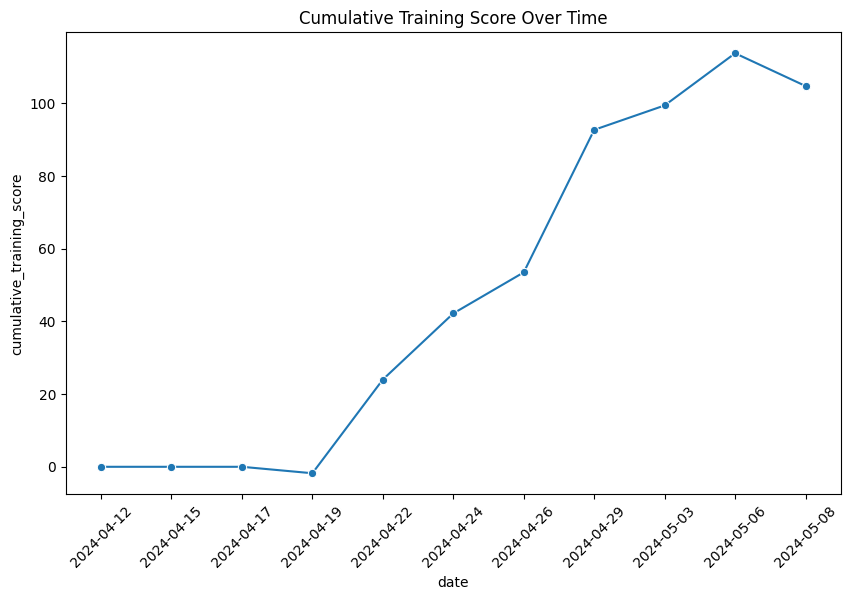

,date,training_score,cumulative_training_score
0,2024-04-12,0.000000,0.000000
1,2024-04-15,0.000000,0.000000
2,2024-04-17,0.000000,0.000000
3,2024-04-19,-1.777397,-1.777397
4,2024-04-22,25.793651,24.016254
5,2024-04-24,18.202160,42.218414
6,2024-04-26,11.300505,53.518919
7,2024-04-29,39.228903,92.747822
8,2024-05-03,6.715868,99.463690
9,2024-05-06,14.362745,113.826435


In [123]:
# Calculate the average training score for each day
average_training_score = average_weights.groupby('date')[
    'training_score'].mean().reset_index()

# Calculate the cumulative training score over time
average_training_score['cumulative_training_score'] = (
    average_training_score['training_score'].cumsum())

# Plot the cumulative training score over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='cumulative_training_score', 
             data=average_training_score, marker='o')
plt.title('Cumulative Training Score Over Time')
plt.xticks(rotation=45)
plt.show()

average_training_score

## Training score by categories

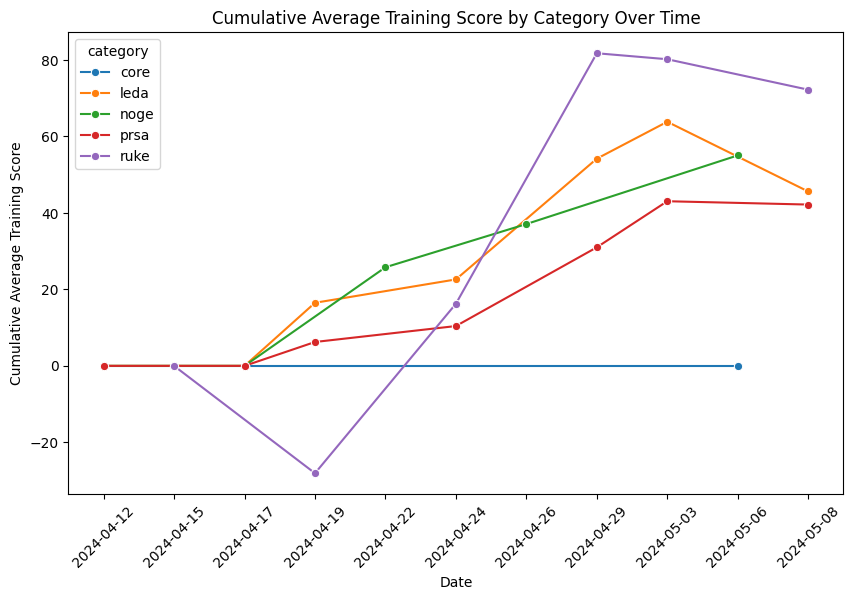

In [124]:
training_score_by_category = average_weights.groupby(['date', 'category'])[
    'training_score'].mean().reset_index()

# Calculate the cumulative training score over time
training_score_by_category['cumulative_training_score'] = (
    training_score_by_category.groupby('category')['training_score'].cumsum())

plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='cumulative_training_score', hue='category', 
             data=training_score_by_category, marker='o')
plt.title('Cumulative Average Training Score by Category Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Average Training Score')
plt.xticks(rotation=45)
plt.show()